<a href="https://colab.research.google.com/github/mohamedGaber2004/HousePricePrediction_GTC/blob/main/HousePricePrediction_GTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read The Data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import joblib

In [7]:
url = "https://docs.google.com/spreadsheets/d/1cbogF9J7EUJdgxhTO28rblOUCqlPJiqbrJMCYTpQtcc/export?format=csv"
df = pd.read_csv(url)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# Split Data for The Modeling

In [11]:
# Target column
y = df["median_house_value"]
X = df.drop(columns=["median_house_value"])

# Numerical & categorical columns
num_cols = X.select_dtypes(include=["float64", "int64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

print("Numerical features:", list(num_cols))
print("Categorical features:", list(cat_cols))

Numerical features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Categorical features: ['ocean_proximity']


# Preprocessing

In [12]:
# 2. Preprocessing

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


# Modeling

In [13]:
# 3. Models

models = {
    "LinearRegression": Pipeline([
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ]),
    "RandomForest": Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
    ]),
    "GradientBoosting": Pipeline([
        ("preprocessor", preprocessor),
        ("model", GradientBoostingRegressor(n_estimators=200, random_state=42))
    ])
}

In [14]:
# 4. Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# 5. Train & evaluate

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    cv_rmse = -cross_val_score(model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()
    results.append({"model": name, "test_RMSE": rmse, "test_R2": r2, "cv_RMSE": cv_rmse})


# Evaluation

In [18]:
results_df = pd.DataFrame(results).sort_values("test_RMSE")
print("\nModel comparison:\n", results_df)


Model comparison:
               model     test_RMSE   test_R2       cv_RMSE
1      RandomForest  2.377124e+09  0.818597  49274.437337
2  GradientBoosting  2.731272e+09  0.791571  51681.493647
0  LinearRegression  4.910637e+09  0.625259  68634.279563


In [19]:
# 6. Best model

best_name = results_df.iloc[0]["model"]
best_model = models[best_name]
print(f"\n The Best model is : {best_name} (test RMSE = {results_df.iloc[0]['test_RMSE']:.2f})")



 The Best model is : RandomForest (test RMSE = 2377124026.62)


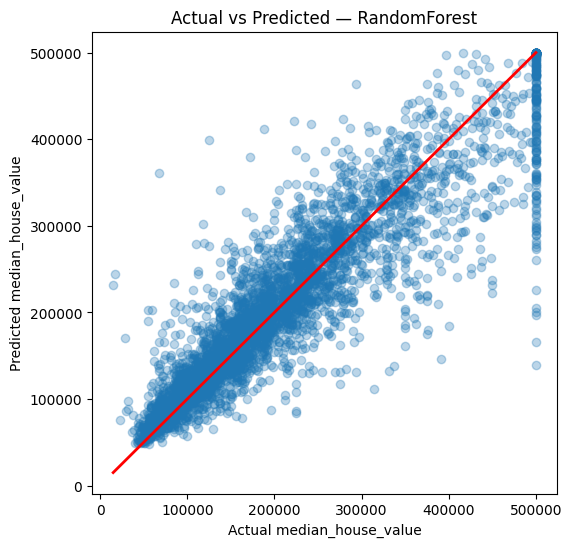

In [20]:
# 7. Predictions vs Actual

y_pred = best_model.predict(X_test)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", lw=2)
plt.xlabel("Actual median_house_value")
plt.ylabel("Predicted median_house_value")
plt.title(f"Actual vs Predicted — {best_name}")
plt.show()